In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

sns.set_style('ticks')
from pathlib import Path
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance

from utils import get_df, evaluate_classifier, numpy_confusion_matrix_to_pycm, save_confusion_matrix_fig 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Set global seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 176 ms


In [3]:
ds.close()

time: 18.7 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 9.07 s


In [5]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2018-01-01', '2019-12-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_polarization = df_polarization.reset_index()  
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on 
# this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 28.5 s


In [6]:
df_sklearn_remapped = df_sklearn.copy()

df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1
    
for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
print(f"Crop types: {class_names}")

Crop types: ['Potato', 'Spring barley', 'Winter barley', 'Spring wheat', 'Winter wheat', 'Winter rye', 'Spring oat', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow', 'Forest']
time: 222 ms


In [7]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, 
                                                    random_state=RANDOM_SEED)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      31033
Test samples:       13300
Number of features: 231
time: 965 ms


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression          
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def get_classifiers(random_seed=42):
    # From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    # Note: GaussianClassifier does not work (maybe requires too much training - kernel restarts in jupyter)
    N_JOBS=24
    classifiers = { 
        #'Nearest Neighbors': GridSearchCV(KNeighborsClassifier(), 
        #                                  param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}, 
        #                                  refit=True, cv=5, n_jobs=N_JOBS),
        'Decision Tree': GridSearchCV(DecisionTreeClassifier(random_state=random_seed, 
                                                             class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}, 
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Random Forest': GridSearchCV(RandomForestClassifier(random_state=random_seed, 
                                                             class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16], 
                                                  'n_estimators': [6, 8, 10, 12, 14], 
                                                  'max_features': [1, 2, 3]},
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Logistic Regression': GridSearchCV(LogisticRegression(max_iter=1000, random_state=random_seed, 
                                                               class_weight='balanced'),
                                            param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                        'penalty': ['none', 'l2']},
                                            refit=True, cv=5, n_jobs=N_JOBS),
        'Linear SVM': GridSearchCV(SVC(kernel='linear', random_state=random_seed, 
                                       class_weight='balanced'),
                                   #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                   param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                                   refit=True, cv=5, n_jobs=N_JOBS),
        'RBF SVM': GridSearchCV(SVC(kernel='rbf', random_state=random_seed, 
                                    class_weight='balanced'),
                                #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                                refit=True, cv=5, n_jobs=N_JOBS),
        'Neural Network': GridSearchCV(MLPClassifier(max_iter=1000, random_state=random_seed),
                                       param_grid={'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                                                   'hidden_layer_sizes': [(50,50,50), (100, 100, 100), (100,)],
                                                   'activation': ['tanh', 'relu'],
                                                   'learning_rate': ['constant','adaptive']},
                                       refit=True, cv=5, n_jobs=N_JOBS)
        }
    
    return classifiers

time: 216 ms


In [9]:
df_clf_results = pd.DataFrame(columns=['Classifier', 'Crop type', 'Prec.', 'Recall', 
                                       'F1-Score', 'Accuracy', 'Samples', 'Random seed'])

clf_trained_dict = {}
report_dict = {}
cm_dict = {}

# TODO: Also calculate uncertainties - ie. use multiple random seeds.
#       Create df (with cols [Clf_name, Random_seed, Acc., Prec., Recall, F1-score]) and loop over random seeds
#       See following on how to format pandas dataframe to get the uncertainties into the df
#       https://stackoverflow.com/questions/46584736/pandas-change-between-mean-std-and-plus-minus-notations
for random_seed in range(10):
    print(f"\n\n########################## RANDOM SEED IS SET TO {random_seed:2d} ##########################") 
    # Seed the random generators
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    
    # Get the train and test sets with the specified random_seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, 
                                                        random_state=random_seed)
    
    # Get the classifiers
    classifiers = get_classifiers(random_seed)
    
    for name, clf in classifiers.items():
        # Evaluate classifier
        print("-------------------------------------------------------------------------------")
        print(f"Evaluating classifier: {name}")
        clf_trained, _, _, results_report, cnf_matrix = evaluate_classifier(
            clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, plot_conf_matrix=False,
            print_classification_report=False)      
        print(f"The best parameters are {clf_trained.best_params_} (score = {clf_trained.best_score_:2f})")

        # Save results in dicts
        clf_trained_dict[f'{name}_random_seed_{random_seed:02}'] = clf_trained
        report_dict[f'{name}_random_seed_{random_seed:02}'] = results_report
        cm_dict[f'{name}_random_seed_{random_seed:02}'] = cnf_matrix
        
        # Save results for individual crops in df
        df_results = pd.DataFrame(results_report).transpose()  
        for crop_type in class_names:
            # Get values
            prec = df_results.loc[crop_type, 'precision']
            recall = df_results.loc[crop_type, 'recall']
            f1 = df_results.loc[crop_type, 'f1-score']
            samples = df_results.loc[crop_type, 'support']
            acc = None

            # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
            df_clf_results.loc[-1] = [name, crop_type, prec, recall, f1, acc, samples, random_seed]
            df_clf_results.index = df_clf_results.index + 1  # shifting index
            df_clf_results = df_clf_results.sort_index()  # sorting by index

        # Save overall results
        prec = df_results.loc['weighted avg', 'precision']
        recall = df_results.loc['weighted avg', 'recall']
        f1 = df_results.loc['weighted avg', 'f1-score']
        acc = df_results.loc['accuracy', 'f1-score']
        samples = df_results.loc['weighted avg', 'support']

        # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
        df_clf_results.loc[-1] = [name, 'Overall', prec, recall, f1, acc, samples, random_seed]
        df_clf_results.index = df_clf_results.index + 1  # shifting index
        df_clf_results = df_clf_results.sort_index()  # sorting by index

        # Save df with results to disk
        save_path = PROJ_PATH / 'notebooks' / '03_TrainClassifiers_results.pkl'
        df_clf_results.to_pickle(save_path)



################################## RANDOM SEED IS SET TO  0 ##################################
-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 23.7022 s
Prediction time: 0.0042 s

Report:

Train accuracy: 0.9357
Test accuracy: 0.865
The best parameters are {'max_depth': 12} with a score of 0.862791
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 14.1725 s
Prediction time: 0.0374 s

Report:

Train accuracy: 0.9879
Test accuracy: 0.9016
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} with a score of 0.901331
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression
Training time: 191.6107 s
Prediction time: 0.0074 s

Report:

Train accuracy: 0.9296
Test accuracy: 0.9222
The best parameters are {'C': 0.01, 'penalty': 'l2'} wi

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 1008.8864 s
Prediction time: 0.0201 s

Report:

Train accuracy: 0.9471
Test accuracy: 0.9374
The best parameters are {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant'} with a score of 0.934876


################################## RANDOM SEED IS SET TO  1 ##################################
-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 23.1556 s
Prediction time: 0.004 s

Report:

Train accuracy: 0.9604
Test accuracy: 0.868
The best parameters are {'max_depth': 14} with a score of 0.860632
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 14.0939 s
Prediction time: 0.0347 s

Report:

Train accuracy: 0.9752
Test accuracy: 0.9007
The best parameters are {'max_depth': 14, 'max_features': 3, 'n_estimators': 14} with a score of 0.903361
-----------------------------

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 1035.8401 s
Prediction time: 0.0761 s

Report:

Train accuracy: 0.9482
Test accuracy: 0.9354
The best parameters are {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant'} with a score of 0.935134


################################## RANDOM SEED IS SET TO  5 ##################################
-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 21.7414 s
Prediction time: 0.0038 s

Report:

Train accuracy: 0.9343
Test accuracy: 0.8623
The best parameters are {'max_depth': 12} with a score of 0.865982
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 13.8463 s
Prediction time: 0.0328 s

Report:

Train accuracy: 0.9623
Test accuracy: 0.9005
The best parameters are {'max_depth': 12, 'max_features': 3, 'n_estimators': 14} with a score of 0.906422
------------------------

In [30]:
# Load the df with results from saved file
load_path = PROJ_PATH / 'notebooks' / '03_TrainClassifiers_results.pkl'
df_clf_results = pd.read_pickle(load_path)

time: 36.3 ms


In [66]:
df_clf_results.head(5)

,Classifier,Crop type,Prec.,Recall,F1-Score,Accuracy,Samples,Random seed
0,Neural Network,Overall,0.93897,0.93940,0.93833,0.93940,13300.00000,9
1,Neural Network,Forest,0.94798,0.84536,0.89373,None,388.00000,9
2,Neural Network,Willow,0.88618,0.86853,0.87726,None,251.00000,9
3,Neural Network,Permanent grass,0.86874,0.96211,0.91304,None,1135.00000,9
4,Neural Network,Rapeseed,0.99911,0.99643,0.99777,None,1121.00000,9


time: 44.9 ms


In [104]:
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
df_clf_results_latex = pd.DataFrame(columns=['', 'Acc.', 'Prec.', 'F1-Score'])

for classifier in df_clf_results['Classifier'].unique():
    stats_vals = [classifier]
    for metric in ['Accuracy', 'Prec.', 'F1-Score']:
        df_clf_results_stats = df_clf_results.copy()
        df_clf_results_stats = df_clf_results_stats[df_clf_results_stats['Crop type'] == 'Overall']
        df_clf_results_stats = df_clf_results_stats[df_clf_results_stats['Classifier'] == classifier]
        mean = np.mean(df_clf_results_stats[metric]*100)
        std = np.std(df_clf_results_stats[metric]*100)
        stats_vals.append(f'${mean:.2f}\pm{std:.2f}$')
        
    # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
    df_clf_results_latex.loc[-1] = stats_vals
    df_clf_results_latex.index = df_clf_results_latex.index + 1  # shifting index
    df_clf_results_latex = df_clf_results_latex.sort_index()  # sorting by index
print(df_clf_results_latex.to_latex(index=False, escape=False, column_format='lcccc'))  

\begin{tabular}{lcccc}
\toprule
                     &            Acc. &           Prec. &        F1-Score \\
\midrule
       Decision Tree &  $86.60\pm0.32$ &  $87.17\pm0.35$ &  $86.81\pm0.33$ \\
       Random Forest &  $90.26\pm0.22$ &  $90.02\pm0.24$ &  $90.00\pm0.24$ \\
 Logistic Regression &  $92.19\pm0.26$ &  $92.53\pm0.24$ &  $92.30\pm0.26$ \\
          Linear SVM &  $92.95\pm0.21$ &  $93.25\pm0.19$ &  $93.04\pm0.21$ \\
             RBF SVM &  $94.02\pm0.25$ &  $94.08\pm0.25$ &  $94.02\pm0.25$ \\
      Neural Network &  $93.56\pm0.26$ &  $93.54\pm0.26$ &  $93.45\pm0.28$ \\
\bottomrule
\end{tabular}

time: 91.5 ms


In [144]:
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
df_clf_results_latex = pd.DataFrame(columns=['', 'Prec.', 'Recall', 'F1-Score', 'Samples'])

for crop_type in df_clf_results['Crop type'].unique():
    if crop_type == 'Overall':
        stats_vals = ['Weighted avg.']
    else:
        stats_vals = [crop_type]
    for metric in ['Prec.', 'Recall', 'F1-Score']:
        df_clf_results_stats = df_clf_results.copy()
        df_clf_results_stats = df_clf_results_stats[df_clf_results_stats['Crop type'] == crop_type]
        df_clf_results_stats = df_clf_results_stats[df_clf_results_stats['Classifier'] == 'RBF SVM']
        mean = np.mean(df_clf_results_stats[metric]*100)
        std = np.std(df_clf_results_stats[metric]*100)
        stats_vals.append(f'${mean:.2f}\pm{std:.2f}$')
    samples = df_clf_results_stats['Samples'].values[0]
    stats_vals.append(int(samples))
    # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
    df_clf_results_latex.loc[-1] = stats_vals
    df_clf_results_latex.index = df_clf_results_latex.index + 1  # shifting index
    df_clf_results_latex = df_clf_results_latex.sort_index()  # sorting by index
    
print(df_clf_results_latex.to_latex(index=False, escape=False, column_format='lcccc'))  

\begin{tabular}{lcccc}
\toprule
                 &           Prec. &          Recall &        F1-Score & Samples \\
\midrule
          Potato &  $97.98\pm0.19$ &  $97.82\pm0.21$ &  $97.90\pm0.14$ &    2251 \\
   Spring barley &  $90.10\pm0.57$ &  $89.74\pm0.59$ &  $89.92\pm0.47$ &    1187 \\
   Winter barley &  $98.73\pm0.41$ &  $96.93\pm0.39$ &  $97.82\pm0.25$ &    1311 \\
    Spring wheat &  $71.43\pm1.42$ &  $72.39\pm1.62$ &  $71.89\pm1.09$ &     482 \\
    Winter wheat &  $92.53\pm0.58$ &  $96.65\pm0.69$ &  $94.54\pm0.52$ &    1114 \\
      Winter rye &  $95.82\pm0.38$ &  $96.47\pm0.57$ &  $96.14\pm0.35$ &    1290 \\
      Spring oat &  $93.08\pm0.51$ &  $85.95\pm1.14$ &  $89.37\pm0.60$ &    1340 \\
           Maize &  $97.10\pm0.46$ &  $97.60\pm0.37$ &  $97.35\pm0.18$ &    1430 \\
        Rapeseed &  $99.84\pm0.10$ &  $99.27\pm0.26$ &  $99.55\pm0.13$ &    1121 \\
 Permanent grass &  $89.11\pm0.91$ &  $94.43\pm0.53$ &  $91.69\pm0.65$ &    1135 \\
          Willow &  $85.35\pm1.65$ 

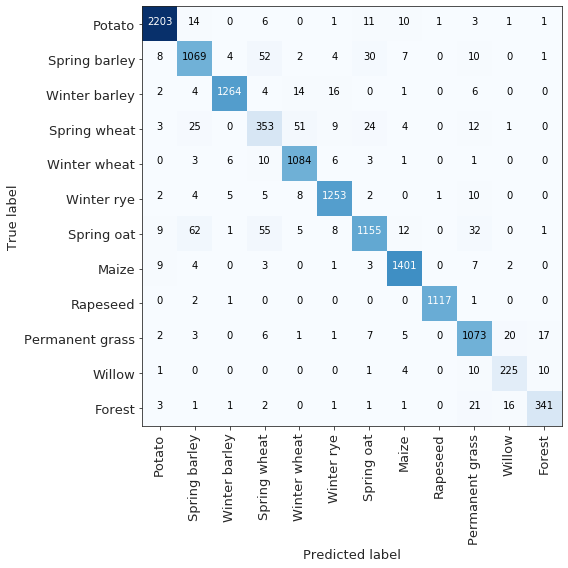

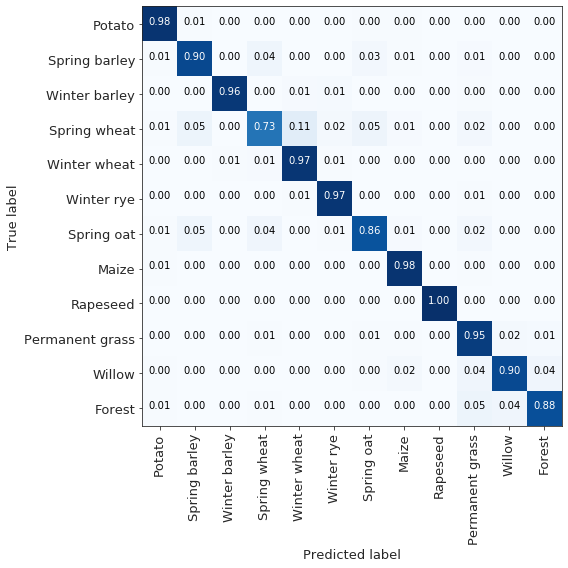

time: 1.44 s


In [165]:
# Save the confusion matrix figure you want
plot_name = 'RBF_SVM_conf_matrix'
plot_path = PROJ_PATH / 'reports' / 'figures' / 'conf_matrices' / plot_name
if not plot_path.parent.exists():
    plot_path.parent.mkdir()
    
save_confusion_matrix_fig(cm_dict['RBF SVM_random_seed_02'], classes=class_names, 
                          save_path=plot_path, fontsize=13)
save_confusion_matrix_fig(cm_dict['RBF SVM_random_seed_02'], classes=class_names, 
                          save_path=plot_path, normalized=True, fontsize=13)

In [172]:
# Key numbers for paper:
total_size_processed_sentinel1 = 294  # [GB]
total_fields_2019 = 587288  
total_area_2019 = 2660101  # [ha]
total_fields_2019_crop_type = 289810
total_area_2019_crop_type = 1720987  # [ha]
crop_type_fields_coverage = total_fields_2019_crop_type / total_fields_2019 * 100  # = 49.34%
print(f'num_fields percentage: {crop_type_fields_coverage}')
crop_type_area_coverage = total_area_2019_crop_type / total_area_2019 * 100  # = 64.69%
print(f'area percentage: {crop_type_area_coverage}')

first_date = '2018-07-08'  # From xarray
last_date = '2019-10-31'  # From xarray
num_dates = 77  # Every 6th day
num_features = 231  # 77*3
total_dataset_size = len(y)  # = 44333  # After buffering and NaN fields have been discarded
print(f'dataset size (after buffering and NaN fields have been discarded): {total_dataset_size}')
train_set_size = len(y_train)  # = 31033  # After buffering and NaN fields have been discarded
print(f'train_set size (after buffering and NaN fields have been discarded): {train_set_size}')
test_set_size = len(y_test)  # = 13300  # After buffering and NaN fields have been discarded
print(f'test_size size (after buffering and NaN fields have been discarded): {test_set_size}')


# From notebook 01_CreateDataset.ipynb

# First we find total number of fields in 2019
### Analyzing FieldPolygons2019 ###
# There are a total of 587288 fields (total area = 2660101 ha)

# Then we find the number of fields with no max. fields per type and 0m buffering
### Analyzing FieldPolygons2019 (after buffering of 0m) ###
#There are a total of 289810 fields (total area = 1720987 ha)
#There are 588 fields (total area = 4877 ha) of type: Kartofler, andre
#There are 465 fields (total area = 3966 ha) of type: Kartofler, lægge- (certificerede)
#There are 758 fields (total area = 4144 ha) of type: Kartofler, lægge- (egen opformering)
#There are 2185 fields (total area = 7930 ha) of type: Kartofler, spise-
#There are 4649 fields (total area = 35727 ha) of type: Kartofler, stivelses-
#There are 53590 fields (total area = 90351 ha) of type: Permanent græs, normalt udbytte
#There are 1370 fields (total area = 2828 ha) of type: Pil
#There are 28073 fields (total area = 186116 ha) of type: Silomajs
#There are 2205 fields (total area = 4671 ha) of type: Skovdrift, alm.
#There are 13553 fields (total area = 99950 ha) of type: Vinterbyg
#There are 65629 fields (total area = 536264 ha) of type: Vinterhvede
#There are 18413 fields (total area = 164197 ha) of type: Vinterraps
#There are 6468 fields (total area = 35022 ha) of type: Vinterrug
#There are 80080 fields (total area = 483420 ha) of type: Vårbyg
#There are 9561 fields (total area = 48932 ha) of type: Vårhavre
#There are 2223 fields (total area = 12585 ha) of type: Vårhvede

# Then we find number of fields with max. fields per type of 5000 and 0m buffering
### Analyzing FieldPolygons2019 (after buffering of 0m) ###
#There are a total of 54443 fields (total area = 322566 ha)
#There are 588 fields (total area = 4877 ha) of type: Kartofler, andre
#There are 465 fields (total area = 3966 ha) of type: Kartofler, lægge- (certificerede)
#There are 758 fields (total area = 4144 ha) of type: Kartofler, lægge- (egen opformering)
#There are 2185 fields (total area = 7930 ha) of type: Kartofler, spise-
#There are 4649 fields (total area = 35727 ha) of type: Kartofler, stivelses-
#There are 5000 fields (total area = 8380 ha) of type: Permanent græs, normalt udbytte
#There are 1370 fields (total area = 2828 ha) of type: Pil
#There are 5000 fields (total area = 33401 ha) of type: Silomajs
#There are 2205 fields (total area = 4671 ha) of type: Skovdrift, alm.
#There are 5000 fields (total area = 36357 ha) of type: Vinterbyg
#There are 5000 fields (total area = 41134 ha) of type: Vinterhvede
#There are 5000 fields (total area = 44321 ha) of type: Vinterraps
#There are 5000 fields (total area = 27063 ha) of type: Vinterrug
#There are 5000 fields (total area = 29849 ha) of type: Vårbyg
#There are 5000 fields (total area = 25326 ha) of type: Vårhavre
#There are 2223 fields (total area = 12585 ha) of type: Vårhvede

# Then we find the number of fields with max. fields per type of 5000 and -20m buffering
### Analyzing FieldPolygons2019 (after buffering of -20m) ###
#There are a total of 52769 fields (total area = 330207 ha)
#There are 581 fields (total area = 4872 ha) of type: Kartofler, andre
#There are 460 fields (total area = 3962 ha) of type: Kartofler, lægge- (certificerede)
#There are 713 fields (total area = 4095 ha) of type: Kartofler, lægge- (egen opformering)
#There are 1687 fields (total area = 7762 ha) of type: Kartofler, spise-
#There are 4610 fields (total area = 35695 ha) of type: Kartofler, stivelses-
#There are 5000 fields (total area = 9656 ha) of type: Permanent græs, normalt udbytte
#There are 1018 fields (total area = 2681 ha) of type: Pil
#There are 5000 fields (total area = 33461 ha) of type: Silomajs
#There are 1587 fields (total area = 4501 ha) of type: Skovdrift, alm.
#There are 5000 fields (total area = 38106 ha) of type: Vinterbyg
#There are 5000 fields (total area = 41364 ha) of type: Vinterhvede
#There are 5000 fields (total area = 45349 ha) of type: Vinterraps
#There are 5000 fields (total area = 27955 ha) of type: Vinterrug
#There are 5000 fields (total area = 31377 ha) of type: Vårbyg
#There are 5000 fields (total area = 26824 ha) of type: Vårhavre
#There are 2113 fields (total area = 12539 ha) of type: Vårhvede

num_fields percentage: 49.34716868044299
area percentage: 64.69630288474009
dataset size (after buffering and NaN fields have been discarded): 44333
train_set size (after buffering and NaN fields have been discarded): 31033
test_size size (after buffering and NaN fields have been discarded): 13300
time: 31.4 ms
